In [1]:
!pip install pycaret
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import os
import scikitplot as skplt
import lightgbm as lgb
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np


# Data preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder

from pycaret.datasets import get_data

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import GridSearchCV

# Data splitting
from sklearn.model_selection import train_test_split, learning_curve

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error, 
    r2_score, 
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay,
    roc_auc_score
)

In [2]:
# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\jasmi\.cache\kagglehub\datasets\blastchar\telco-customer-churn\versions\1


In [3]:
#Use the file path to load a dataframe
#file_path = os.path.join(path, "telco-customer-churn.csv")
file_path = r"C:\Users\jasmi\.cache\kagglehub\datasets\blastchar\telco-customer-churn\versions\1\WA_Fn-UseC_-Telco-Customer-Churn.csv"

df = pd.read_csv(file_path)

display(df)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [4]:
# Drop unique ID column
df_revised = df.drop(columns=["customerID"])

# Fill missing values in original df first (for columns that have NaNs)
# Use mode for categorical columns before encoding
for col in ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 
            'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
            'StreamingMovies', 'PaperlessBilling', 'Contract', 'PaymentMethod', 'Churn']:
    df_revised[col] = df_revised[col].fillna(df_revised[col].mode()[0])

# Encode binary columns with map
df_revised['gender'] = df_revised['gender'].map({'Female': 1, 'Male': 0})
df_revised['Partner'] = df_revised['Partner'].map({'Yes': 1, 'No': 0})
df_revised['Dependents'] = df_revised['Dependents'].map({'Yes': 1, 'No': 0})
df_revised['PhoneService'] = df_revised['PhoneService'].map({'Yes': 1, 'No': 0})
df_revised['OnlineSecurity'] = df_revised['OnlineSecurity'].map({'Yes': 1, 'No': 0})
df_revised['OnlineBackup'] = df_revised['OnlineBackup'].map({'Yes': 1, 'No': 0})
df_revised['DeviceProtection'] = df_revised['DeviceProtection'].map({'Yes': 1, 'No': 0})
df_revised['TechSupport'] = df_revised['TechSupport'].map({'Yes': 1, 'No': 0})
df_revised['StreamingTV'] = df_revised['StreamingTV'].map({'Yes': 1, 'No': 0})
df_revised['StreamingMovies'] = df_revised['StreamingMovies'].map({'Yes': 1, 'No': 0})
df_revised['PaperlessBilling'] = df_revised['PaperlessBilling'].map({'Yes': 1, 'No': 0})
df_revised['Churn'] = df_revised['Churn'].map({'Yes': 1, 'No': 0})

# Encode categorical columns with more than two categories
df_revised['MultipleLines'] = pd.Categorical(df_revised['MultipleLines']).codes
df_revised['InternetService'] = pd.Categorical(df_revised['InternetService']).codes
df_revised['Contract'] = pd.Categorical(df_revised['Contract']).codes
df_revised['PaymentMethod'] = pd.Categorical(df_revised['PaymentMethod']).codes

# Now split X and y from df_revised
X = df_revised.drop('Churn', axis=1)
y = df_revised['Churn']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
# Step 1: Clean TotalCharges in df_revised
df_revised['TotalCharges'] = df_revised['TotalCharges'].replace(' ', np.nan)
df_revised['TotalCharges'] = df_revised['TotalCharges'].astype(float)

# Step 2: Drop rows with missing values (optional but common before scaling)
df_revised = df_revised.dropna()

# Step 3: Redefine X and y using cleaned data
X = df_revised.drop('Churn', axis=1)  # replace 'target_column' with your actual target
y = df_revised['Churn']


# Step 5: Train-test split (after cleaning!)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Now safely scale
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

display(df_revised)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,0,1,0,1,0,1,0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,2,29.85,29.85,0
1,0,0,0,0,34,1,0,0,1.0,0.0,1.0,0.0,0.0,0.0,1,0,3,56.95,1889.50,0
2,0,0,0,0,2,1,0,0,1.0,1.0,0.0,0.0,0.0,0.0,0,1,3,53.85,108.15,1
3,0,0,0,0,45,0,1,0,1.0,0.0,1.0,1.0,0.0,0.0,1,0,0,42.30,1840.75,0
4,1,0,0,0,2,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0,1,2,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0,1,1,24,1,2,0,1.0,0.0,1.0,1.0,1.0,1.0,1,1,3,84.80,1990.50,0
7039,1,0,1,1,72,1,2,1,0.0,1.0,1.0,0.0,1.0,1.0,1,1,1,103.20,7362.90,0
7040,1,0,1,1,11,0,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0,1,2,29.60,346.45,0
7041,0,1,1,0,4,1,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0,1,3,74.40,306.60,1


In [6]:
#Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of the variance
X_pca_train = pca.fit_transform(X_scaled_train)
X_pca_test = pca.transform(X_scaled_test)

#Explained variance
print("Original number of features:", X.shape[1])
print("Reduced number of PCA components:", X_pca_train.shape[1])
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total explained variance:", np.sum(pca.explained_variance_ratio_))

Original number of features: 19
Reduced number of PCA components: 15
Explained variance ratio: [0.24854702 0.13961582 0.06500989 0.05895704 0.05719073 0.05270544
 0.04632511 0.04528331 0.0440397  0.04099935 0.0377088  0.03689112
 0.02976793 0.02918913 0.02617173]
Total explained variance: 0.9584021367033858


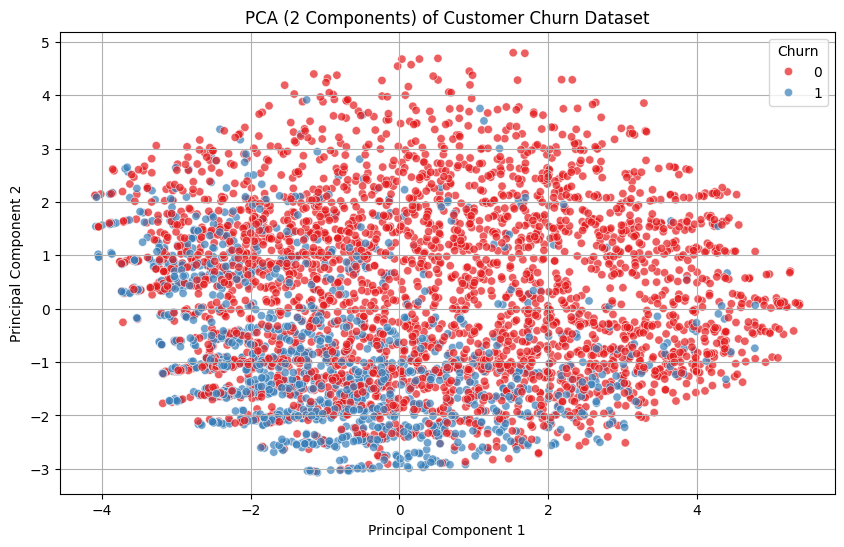

In [7]:
# Re-run PCA with 2 components for visualization
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled_train)

# Create a DataFrame for visualization
pca_df = pd.DataFrame(data=X_pca_2d, columns=['PC1', 'PC2'])
pca_df['Churn'] = y_train.values

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Churn', palette='Set1', alpha=0.7)
plt.title('PCA (2 Components) of Customer Churn Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Churn')
plt.grid(True)
plt.show()

In [8]:
# Logistic Regression
print("Training LR...")
# Initialize Logistic Regression classifier
logreg = LogisticRegression(random_state=42, max_iter=1000)

# Fit the model on PCA-transformed training data
logreg.fit(X_pca_train, y_train)

# Predict on the PCA-transformed test data
y_pred_logreg = logreg.predict(X_pca_test)

# Evaluate the model
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
print("Classification Report:\n", classification_report(y_test, y_pred_logreg))

Training LR...
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.87      0.83       746
           1       0.67      0.55      0.60       357

    accuracy                           0.77      1103
   macro avg       0.74      0.71      0.72      1103
weighted avg       0.76      0.77      0.76      1103



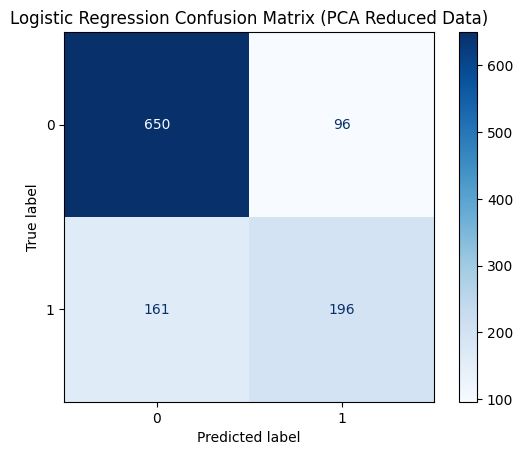

In [9]:
# Display the confusion matrix
disp_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=logreg.classes_)
disp_logreg.plot(cmap='Blues', values_format='d')
plt.title("Logistic Regression Confusion Matrix (PCA Reduced Data)")
plt.show()

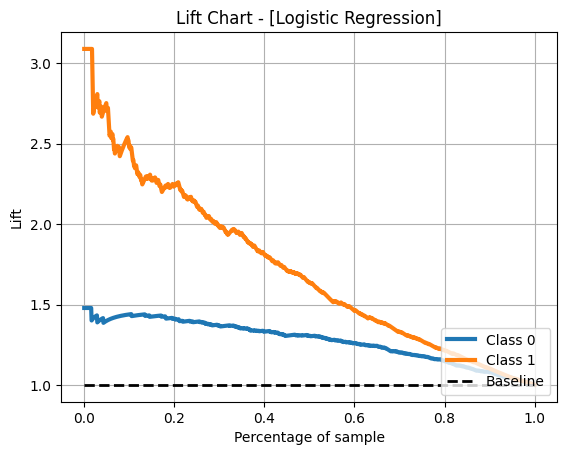

In [10]:
# Get predicted probabilities
y_proba = logreg.predict_proba(X_pca_test)

# Plot lift chart
skplt.metrics.plot_lift_curve(y_test, y_proba)
plt.title("Lift Chart - [Logistic Regression]")
plt.show()

In [11]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf']
}

grid = GridSearchCV(SVC(), param_grid, cv=5)
grid.fit(X_pca_train, y_train)

print("Best Parameters:", grid.best_params_)

# Predict with best model
y_pred = grid.predict(X_pca_test)

Best Parameters: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}


In [12]:
# SVM
# Initialize SVM classifier
svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

# Fit the model on PCA-transformed training data
svm.fit(X_pca_train, y_train)

# Predict on the PCA-transformed test data
y_pred = svm.predict(X_pca_test)

# Evaluate the model
cm = confusion_matrix(y_test, y_pred)
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.89      0.84       746
           1       0.68      0.50      0.58       357

    accuracy                           0.76      1103
   macro avg       0.74      0.69      0.71      1103
weighted avg       0.75      0.76      0.75      1103



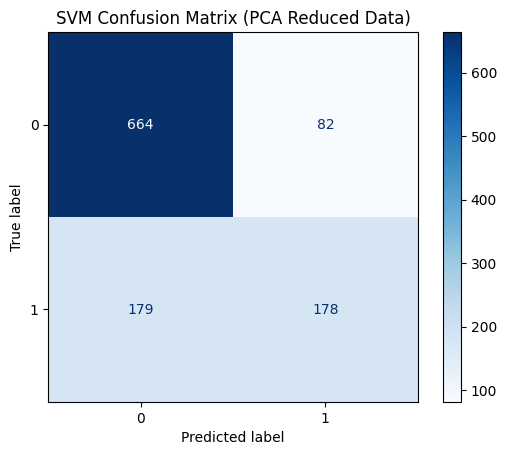

In [13]:
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("SVM Confusion Matrix (PCA Reduced Data)")
plt.show()

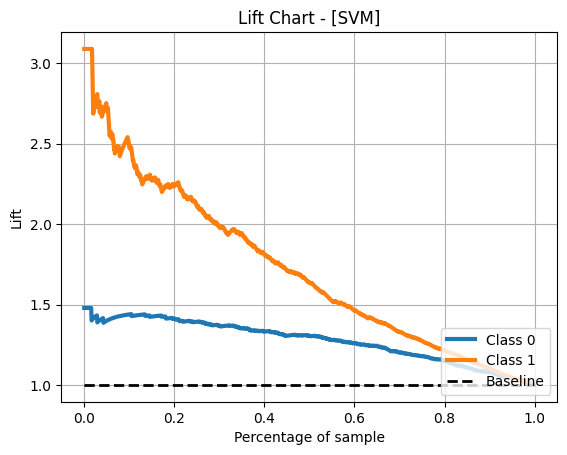

In [14]:
# Get predicted probabilities
y_proba = logreg.predict_proba(X_pca_test)

# Plot lift chart
skplt.metrics.plot_lift_curve(y_test, y_proba)
plt.title("Lift Chart - [SVM]")
plt.show()

In [15]:
# Select top 10 features using ANOVA F-test
selector = SelectKBest(score_func=f_classif, k=10)
X_new = selector.fit_transform(X_scaled_train, y_train)

# Get selected feature names
mask = selector.get_support()
selected_features_kbest = X_train.columns[mask]

print("Top 10 features by SelectKBest:")
print(selected_features_kbest)

Top 10 features by SelectKBest:
Index(['Partner', 'tenure', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'Contract',
       'PaymentMethod', 'TotalCharges'],
      dtype='object')


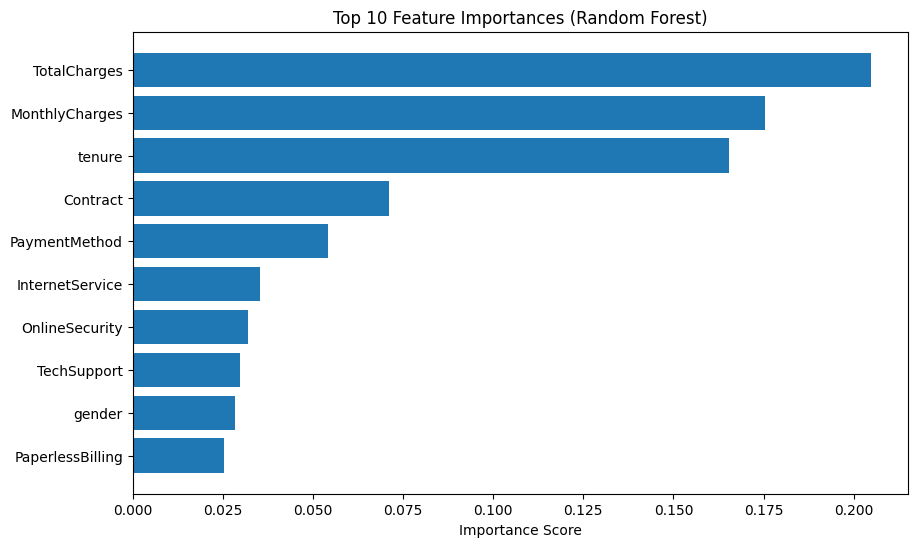

test cell: success


In [16]:
#Plotting feature importance according to Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_scaled_train, y_train)

# Get feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_train.columns

# Plot top 10 important features
plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances (Random Forest)")
plt.barh(range(10), importances[indices[:10]][::-1], align='center')
plt.yticks(range(10), feature_names[indices[:10]][::-1])
plt.xlabel("Importance Score")
plt.show()
print("test cell: success")

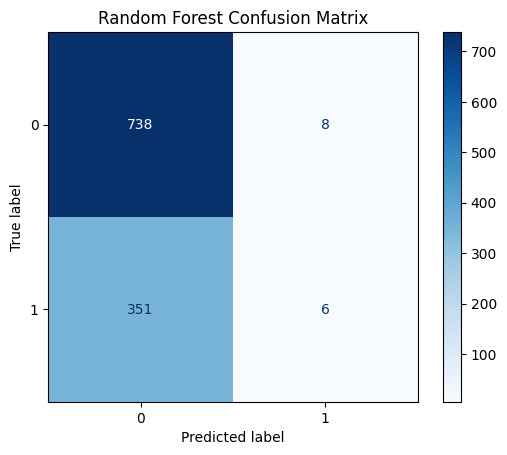

In [17]:
#Confusion Matrix of Random Forest
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.99      0.80       746
           1       0.43      0.02      0.03       357

    accuracy                           0.67      1103
   macro avg       0.55      0.50      0.42      1103
weighted avg       0.60      0.67      0.55      1103



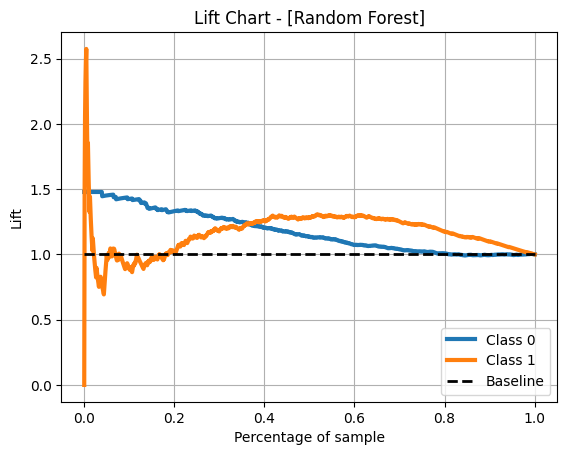

In [19]:
# Get predicted probabilities
y_proba = rf.predict_proba(X_test)

# Plot lift chart
skplt.metrics.plot_lift_curve(y_test, y_proba)
plt.title("Lift Chart - [Random Forest]")
plt.show()

In [20]:
#Overlap of Important Features
top_kbest = set(selected_features_kbest)
top_rf = set(feature_names[indices[:10]])

print("Overlap between SelectKBest and RandomForestClassifier:")
print(top_kbest.intersection(top_rf))

Overlap between SelectKBest and RandomForestClassifier:
{'InternetService', 'OnlineSecurity', 'Contract', 'TechSupport', 'TotalCharges', 'PaymentMethod', 'tenure'}


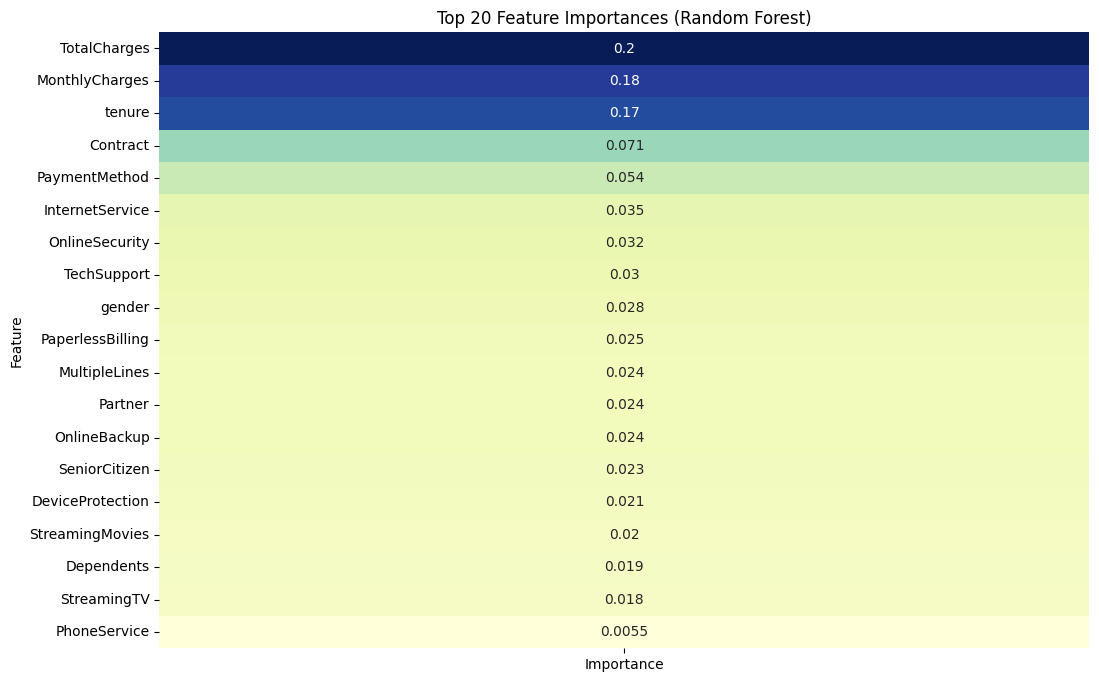

In [21]:
# Create a DataFrame of features and their importances
feature_importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Set feature name as index
feature_importances_df.set_index('Feature', inplace=True)

# Plot as heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(feature_importances_df.head(20), annot=True, cmap='YlGnBu', cbar=False)
plt.title("Top 20 Feature Importances (Random Forest)")
plt.show()

In [22]:
# Initialize LightGBM classifier
lgbm = lgb.LGBMClassifier(random_state=42)

# Fit the model
lgbm.fit(X_train, y_train)

# Predict
y_pred = lgbm.predict(X_test)

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 1399, number of negative: 3010
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 619
[LightGBM] [Info] Number of data points in the train set: 4409, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.317306 -> initscore=-0.766182
[LightGBM] [Info] Start training from score -0.766182
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.85      0.83       746
           1       0.64      0.55      0.60       357

    accuracy                           0.76      1103
   macro avg       0.72      0.70      0.71      1103
weighted avg       0.75      0.76      0.75      1103



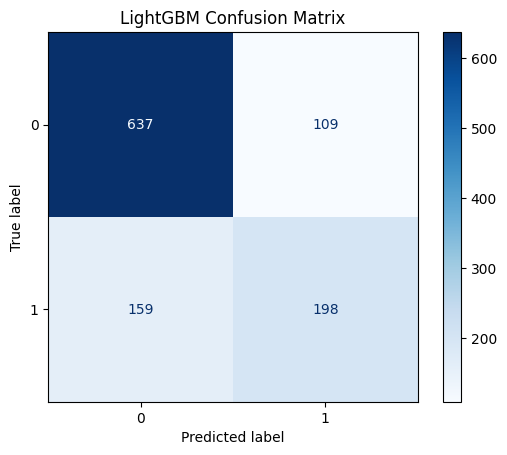

In [23]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgbm.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("LightGBM Confusion Matrix")
plt.show()

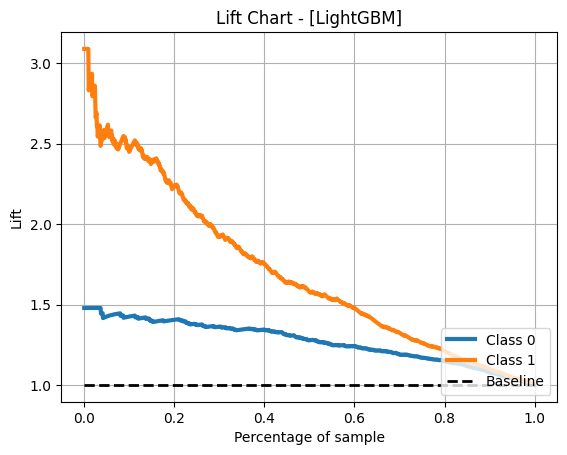

In [24]:
# Get predicted probabilities
y_proba = lgbm.predict_proba(X_test)

# Plot lift chart
skplt.metrics.plot_lift_curve(y_test, y_proba)
plt.title("Lift Chart - [LightGBM]")
plt.show()